In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# ==========================================
# 1. DEFINE THE MODEL
# ==========================================
class MAMLModel(nn.Module):
    def __init__(self):
        super(MAMLModel, self).__init__()
        # 2 inputs (x,y) -> 40 hidden -> 40 hidden -> 1 output
        self.w1 = nn.Parameter(torch.randn(40, 2) * 0.1)
        self.b1 = nn.Parameter(torch.zeros(40))
        self.w2 = nn.Parameter(torch.randn(40, 40) * 0.1)
        self.b2 = nn.Parameter(torch.zeros(40))
        self.w3 = nn.Parameter(torch.randn(1, 40) * 0.1)
        self.b3 = nn.Parameter(torch.zeros(1))

    def forward(self, x, params=None):
        if params is None:
            params = OrderedDict([
                ('w1', self.w1), ('b1', self.b1),
                ('w2', self.w2), ('b2', self.b2),
                ('w3', self.w3), ('b3', self.b3)
            ])
        x = F.linear(x, params['w1'], params['b1'])
        x = F.relu(x)
        x = F.linear(x, params['w2'], params['b2'])
        x = F.relu(x)
        x = F.linear(x, params['w3'], params['b3'])
        return x

In [2]:
# 2. DEFINE DATA GENERATOR
# ==========================================
def generate_circle_task(K_support=10, K_query=100):
    cx, cy = np.random.uniform(-3, 3, size=2)
    radius = 2.0
    x = np.random.uniform(-5, 5, size=(K_support + K_query, 2))
    dist = np.sqrt((x[:,0]-cx)**2 + (x[:,1]-cy)**2)
    y = (dist < radius).astype(np.float32).reshape(-1, 1)

    return {
        'support_x': torch.tensor(x[:K_support], dtype=torch.float32),
        'support_y': torch.tensor(y[:K_support], dtype=torch.float32),
        'query_x': torch.tensor(x[K_support:], dtype=torch.float32),
        'query_y': torch.tensor(y[K_support:], dtype=torch.float32)
    }

In [3]:
# ==========================================
# 3. TRAINING FUNCTION
# ==========================================
def train_maml(model, epochs=2000):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCEWithLogitsLoss()

    print(f"Starting MAML Training ({epochs} epochs)...")

    for epoch in range(epochs):
        optimizer.zero_grad()
        meta_loss = 0.0

        # Batch of tasks (size 20)
        for _ in range(20):
            task = generate_circle_task()

            # Inner Loop (Adaptation)
            # 1. Forward pass on Support
            curr_params = OrderedDict(model.named_parameters())
            logits = model(task['support_x'], params=curr_params)
            loss = loss_fn(logits, task['support_y'])

            # 2. Compute Gradient (create_graph=True for Meta-Learning)
            grads = torch.autograd.grad(loss, curr_params.values(), create_graph=True)

            # 3. Update Weights (Fast Weights)
            fast_weights = OrderedDict(
                (name, param - 0.1 * grad)
                for (name, param), grad in zip(curr_params.items(), grads)
            )

            # Outer Loop (Meta-Loss)
            # Evaluate Fast Weights on Query Set
            logits_q = model(task['query_x'], params=fast_weights)
            loss_q = loss_fn(logits_q, task['query_y'])
            meta_loss += loss_q

        meta_loss /= 20
        meta_loss.backward()
        optimizer.step()

        if epoch % 200 == 0:
            print(f"Epoch {epoch}: Loss = {meta_loss.item():.4f}")

In [4]:
# ==========================================
# 4. EVALUATION FUNCTION
# ==========================================
def evaluate(model, steps=10):
    task = generate_circle_task()
    fast_weights = OrderedDict(model.named_parameters())
    accuracies = []

    for _ in range(steps):
        # Record Accuracy
        with torch.no_grad():
            logits = model(task['query_x'], params=fast_weights)
            preds = (torch.sigmoid(logits) > 0.5).float()
            acc = (preds == task['query_y']).float().mean().item()
            accuracies.append(acc)

        # Update Weights
        logits = model(task['support_x'], params=fast_weights)
        loss = F.binary_cross_entropy_with_logits(logits, task['support_y'])
        grads = torch.autograd.grad(loss, fast_weights.values())

        fast_weights = OrderedDict(
            (name, param - 0.1 * grad)
            for (name, param), grad in zip(fast_weights.items(), grads)
        )
    return accuracies

Starting MAML Training (2000 epochs)...
Epoch 0: Loss = 0.6238
Epoch 200: Loss = 0.2971
Epoch 400: Loss = 0.2459
Epoch 600: Loss = 0.2313
Epoch 800: Loss = 0.2530
Epoch 1000: Loss = 0.2241
Epoch 1200: Loss = 0.2541
Epoch 1400: Loss = 0.2592
Epoch 1600: Loss = 0.2316
Epoch 1800: Loss = 0.2515
Evaluating...


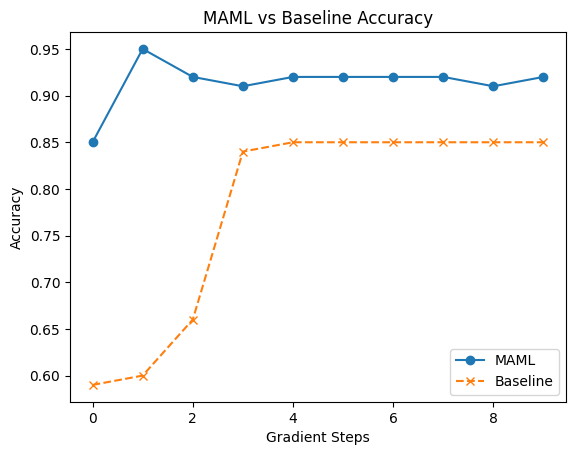

In [7]:
# ==========================================
# 5. EXECUTION BLOCK (RUNS EVERYTHING)
# ==========================================

# A. Train MAML
maml = MAMLModel()
train_maml(maml, epochs=2000)

# B. Create Baseline (Random/Untrained)
baseline = MAMLModel()

# C. Compare
print("Evaluating...")
maml_acc = evaluate(maml)
base_acc = evaluate(baseline)

# D. Plot
plt.plot(maml_acc, marker='o', label='MAML')
plt.plot(base_acc, marker='x', linestyle='--', label='Baseline')
plt.legend()
plt.title("MAML vs Baseline Accuracy")
plt.xlabel("Gradient Steps")
plt.ylabel("Accuracy")
plt.show()

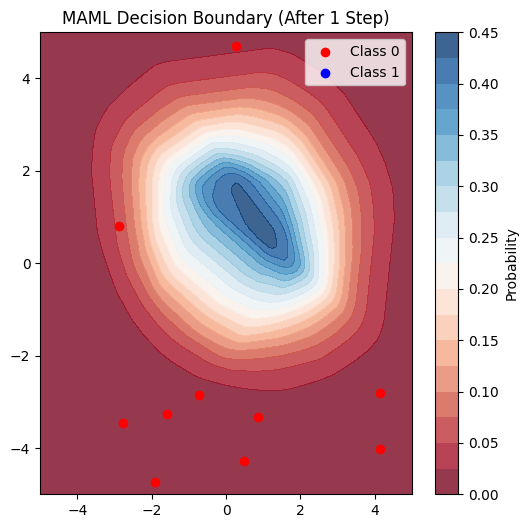

In [8]:
def plot_heatmap(model):
    # 1. Generate a single random task
    task = generate_circle_task()

    # 2. Adapt MAML to this task (1 step)
    fast_weights = OrderedDict(model.named_parameters())

    # Forward pass on Support Set
    logits = model(task['support_x'], params=fast_weights)
    loss = F.binary_cross_entropy_with_logits(logits, task['support_y'])
    grads = torch.autograd.grad(loss, fast_weights.values())

    # Update weights
    fast_weights = OrderedDict(
        (name, param - 0.1 * grad)
        for (name, param), grad in zip(fast_weights.items(), grads)
    )

    # 3. Create a Grid of points to visualize decision boundary
    xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    # 4. Predict on the Grid
    with torch.no_grad():
        logits = model(grid_tensor, params=fast_weights)
        preds = torch.sigmoid(logits).reshape(100, 100).numpy()

    # 5. Plot
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, preds, levels=20, cmap='RdBu', alpha=0.8)
    plt.colorbar(label='Probability')

    # Plot the True Circle
    circle = plt.Circle((0,0), 2.0, color='black', fill=False, linestyle='--', linewidth=2)
    # Note: We can't plot the exact true circle easily without knowing the random center
    # used inside the task generation unless we return it, but the heatmap should LOOK like a circle!

    # Plot the Support Points (the 10 points used to learn)
    sx = task['support_x'].numpy()
    sy = task['support_y'].numpy()
    plt.scatter(sx[sy.flatten()==0, 0], sx[sy.flatten()==0, 1], c='red', label='Class 0')
    plt.scatter(sx[sy.flatten()==1, 0], sx[sy.flatten()==1, 1], c='blue', label='Class 1')

    plt.title("MAML Decision Boundary (After 1 Step)")
    plt.legend()
    plt.show()

# Run the heatmap
plot_heatmap(maml)